# Cohort description and statistics

## Imports

In [1]:
import pandas as pd
import os
from pycirclize import Circos
import numpy as np

import matplotlib.pyplot as plt
from legendkit import cat_legend, hstack, vstack
import matplotlib.font_manager as font_manager
from io import BytesIO
from PIL import Image

## Graphic parameters

In [2]:
plt.rcParams.update({'axes.facecolor': "white"})

legend_font_params = font_manager.FontProperties(family='Calibri',
                                                 weight='normal',
                                                 style='normal',
                                                 size=12)

SIZE_PCT_OF_ORIGINAL = 1.25

np.random.seed(0)

## Load data

Load dataset, and convert variable name/values into understandable text

In [3]:
dataset_path = r"C:\Users\flori\Dropbox (Partners HealthCare)\Floris\SPECTR-MS\data\v9.0\dataset"
dataset = pd.DataFrame(pd.read_hdf(os.path.join(dataset_path, "dataset_final.h5")))
print(len(dataset))

# filter out unusable ms data
dataset = dataset.loc[dataset.QC_MSRAW_Data_Available, :]
print(f"    > Filtered to {dataset.shape=} after removing missing/invalid MS data")  # 18052 samples
dataset = dataset.loc[~dataset.QC_MS_Noise_Filter_Triggered, :]
print(f"    > Filtered to {dataset.shape=} after removing samples triggering noise filter")  # 17151 samples
ready_for_optilite = False

dataset["Total_Mod"] = "All"
dataset["Age_Mod"] = dataset.AGE.apply(lambda x: "Age unknown" if pd.isna(x) else "Age <50" if x < 50 else "Age 50-65" if x < 65 else "Age >65")
dataset["Race_Mod"] = dataset.RACE.apply(
    lambda x: "Black/African American" if x == "Black" else "White/European" if x == "White" else "Other or undisclosed race")
dataset["Sex_Mod"] = dataset.SEX.apply(lambda x: "Female" if x == "F" else "Male" if x == "M" else "Unknown or undisclosed sex")
dataset["Global_Diagnosis_Mod"] = dataset.GLOBAL_DIAGNOSIS.apply(
    lambda x: x if x in ["Negative", "MGIP-Low", "MGIP-High", "LC-MGUS", "MGUS"] else "Disease unknown")
dataset["Ethnic_Group_Mod"] = dataset.ETHNIC_GROUP.apply(lambda x: "Unknown or undisclosed etchnic group" if x == "Unknown" else x)

# change the LC-MGUS and MGUS names to MG:
dataset.loc[dataset["Global_Diagnosis_Mod"] == "MGUS", "Global_Diagnosis_Mod"] = "SPEP-MG"
dataset.loc[dataset["Global_Diagnosis_Mod"] == "LC-MGUS", "Global_Diagnosis_Mod"] = "LC-MG"

dataset["Sr_Race_Mod"] = dataset.RACE.apply(
    lambda x: "Black" if x == "Black" else "White" if x == "White" else "Other or undisclosed race")
dataset.loc[dataset.ETHNIC_GROUP == "Unknown", "Sr_Race_Mod"] = "Other or undisclosed race"
dataset.loc[dataset.ETHNIC_GROUP == "Hispanic or Latino", "Sr_Race_Mod"] = "Hispanics"

print("Dataset length")
print(len(dataset))  # 17151 samples total

# extract and format data

filt = (~dataset.ANON_ID.isna())
filt = filt & dataset.Global_Diagnosis_Mod.isin(["Negative", "MGIP-Low", "MGIP-High", "LC-MG", "SPEP-MG"])
filt_dataset = dataset[filt].copy()

filt_dataset["Sr_Race_Mod"] = filt_dataset["Sr_Race_Mod"].str.replace("Other or undisclosed race", "Other")
filt_dataset["Sex_Mod"] = filt_dataset["Sex_Mod"].str.replace("Unknown or undisclosed sex", "Unknown")
filt_dataset["Age_Mod"] = filt_dataset["Age_Mod"].str.replace("Age unknown", "Unknown")
filt_dataset["Global_Diagnosis_Mod"] = filt_dataset["Global_Diagnosis_Mod"].str.replace("MGIP-.+$", "MGIP")

n_patients = len(filt_dataset)  # 17047
print("Number of patients after removing undisclosed/unavailable/missing")
print(n_patients)

18115
    > Filtered to dataset.shape=(18052, 39) after removing missing/invalid MS data
    > Filtered to dataset.shape=(17151, 39) after removing samples triggering noise filter
Dataset length
17151
Number of patients after removing undisclosed/unavailable/missing
17047


We can then do some stats on the dataset

In [4]:
filt_dataset[
    filt_dataset.AGE.isna() | filt_dataset.Race_Mod.isin(["White/European", "Black/African American"]) | filt_dataset.Sex_Mod.isin(
        ["Female", "Male"])].GLOBAL_DIAGNOSIS.value_counts()

GLOBAL_DIAGNOSIS
Negative     9017
MGUS         3899
MGIP-High    1755
MGIP-Low     1634
LC-MGUS       441
Name: count, dtype: int64

In [5]:
filt_dataset.COHORT.value_counts()

COHORT
MGB               7272
PROMISE_USA       4098
PLCO_1-2.2        2225
PROMISE_SA        1985
PROMISE_SERIAL     645
PCROWD             643
SU2C                96
PCROWD/SU2C         83
Name: count, dtype: int64

In [6]:
filt_dataset.GLOBAL_DIAGNOSIS.value_counts()

GLOBAL_DIAGNOSIS
Negative     9214
MGUS         3947
MGIP-High    1783
MGIP-Low     1657
LC-MGUS       446
Name: count, dtype: int64

In [7]:
filt_dataset.Sr_Race_Mod.value_counts()

Sr_Race_Mod
White        9086
Black        5125
Other        2188
Hispanics     648
Name: count, dtype: int64

In [8]:
filt_dataset.Sex_Mod.value_counts()

Sex_Mod
Female     9860
Male       6786
Unknown     401
Name: count, dtype: int64

In [9]:
filt_dataset.Age_Mod.value_counts()

Age_Mod
Age 50-65    7126
Age <50      5340
Age >65      4502
Unknown        79
Name: count, dtype: int64

In [10]:
filt_dataset.AGE.quantile([.25, .5, .75])

0.25    46.425462
0.50    57.000000
0.75    65.000000
Name: AGE, dtype: float64

In [11]:
filt_dataset.Global_Diagnosis_Mod.value_counts()

Global_Diagnosis_Mod
Negative     9214
SPEP-MG      3947
MGIP-High    1783
MGIP-Low     1657
LC-MG         446
Name: count, dtype: int64

In [12]:
filt_dataset.GLOBAL_DIAGNOSIS.value_counts()

GLOBAL_DIAGNOSIS
Negative     9214
MGUS         3947
MGIP-High    1783
MGIP-Low     1657
LC-MGUS       446
Name: count, dtype: int64

In [13]:
filt_dataset.COHORT.value_counts()

COHORT
MGB               7272
PROMISE_USA       4098
PLCO_1-2.2        2225
PROMISE_SA        1985
PROMISE_SERIAL     645
PCROWD             643
SU2C                96
PCROWD/SU2C         83
Name: count, dtype: int64

First, we can plot the circlos plot

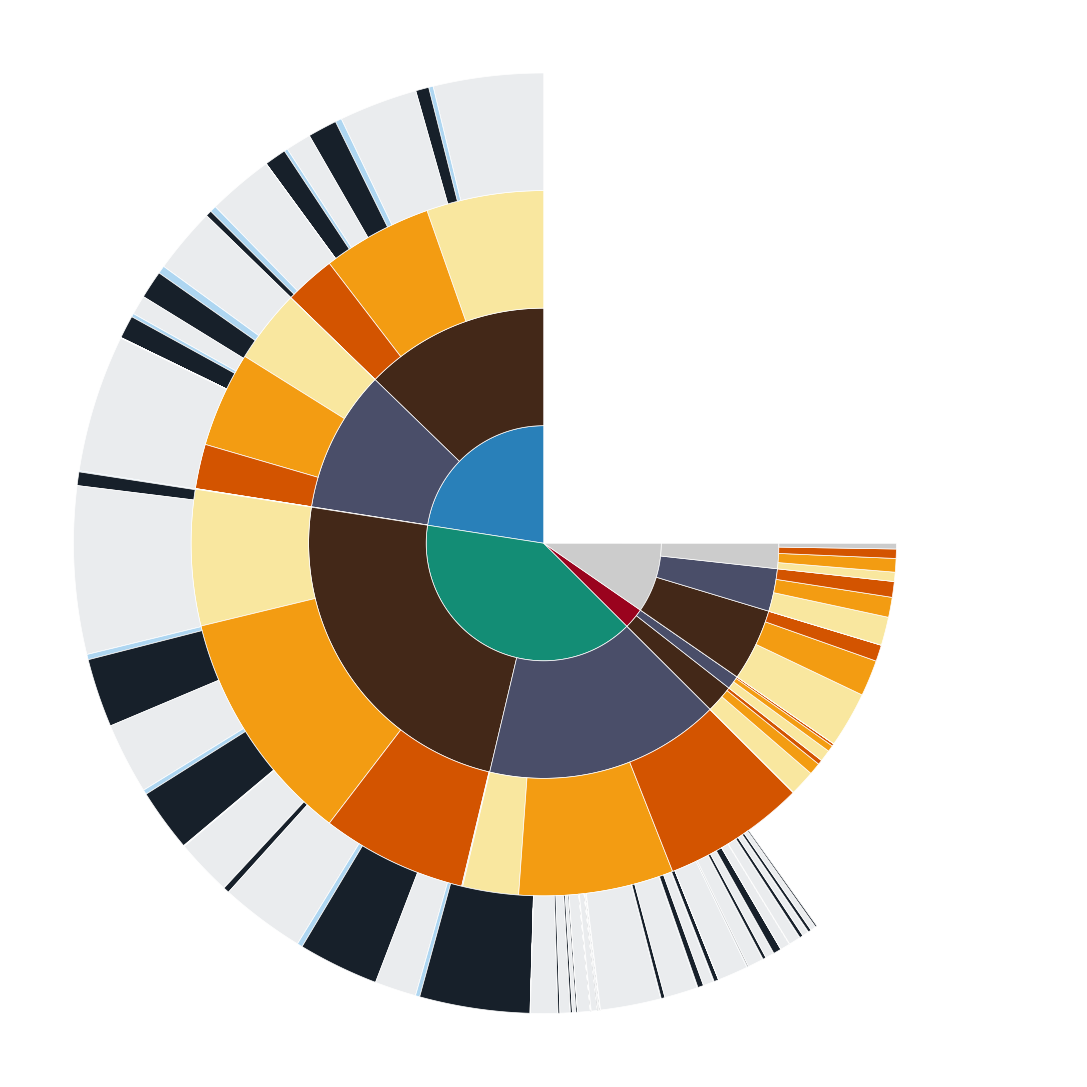

In [14]:
# mg_color_dict = {"Negative": "#eaecee", "MGIP-Low": "#abb2b9", "MGIP-High": "#566573", "LC-MG": "#aed6f1", "SPEP-MG": "#17202a"}
mg_color_dict = {"Negative": "#eaecee", "MGIP": "#abb2b9", "LC-MG": "#aed6f1", "SPEP-MG": "#17202a"}
race_color_dict = {"White": "#138d75", "Black": "#2980b9", "Hispanics": "#9a031e", "Other": "#cccccc"}
sex_color_dict = {"Female": "#432818", "Male": "#4a4e69", "Unknown": "#cccccc"}
age_color_dict = {"Age <50": "#f9e79f", "Age 50-65": "#f39c12", "Age >65": "#d35400", "Unknown": "#cccccc"}

# mg_text_color_dict = {"Negative": "#000000", "MGIP-Low": "#000000", "MGIP-High": "#000000", "LC-MG": "#000000", "SPEP-MG": "#ffffff"}
mg_text_color_dict = {"Negative": "#000000", "MGIP": "#000000", "LC-MG": "#ffffff", "SPEP-MG": "#ffffff"}
race_text_color_dict = {"White": "#ffffff", "Black": "#ffffff", "Hispanics": "#ffffff", "Other": "#000000"}
sex_text_color_dict = {"Female": "#ffffff", "Male": "#ffffff", "Unknown": "#000000"}
age_text_color_dict = {"Age <50": "#000000", "Age 50-65": "#000000", "Age >65": "#000000", "Unknown": "#000000"}

sectors = {"A": n_patients}
circos = Circos(sectors, space=0)
# select first sector (the one with data)
sector = circos.sectors[0]

race_track = sector.add_track((0, 25))
# ethnic_track = sector.add_track((30, 50))
sex_track = sector.add_track((25, 50))
age_track = sector.add_track((50, 75))
mg_track = sector.add_track((75, 100))

race_starting_x = 0
eth_starting_x = 0
sex_starting_x = 0
age_starting_x = 0
mg_starting_x = 0

ec_color = "white"
ec_lw = .5
max_radius_pct = .75
clock_wise = False


def adjust_xpos(xpos, n_patients=n_patients, max_radius_pct=max_radius_pct, clock_wise=clock_wise):
    # linearly adjust if needed
    adj_xpos = xpos if max_radius_pct == 1 else int(round(max_radius_pct * xpos))
    # reverse if counter clockwise
    adj_xpos = adj_xpos if clock_wise else n_patients - adj_xpos
    return adj_xpos


race_order = ["Black", "White", "Hispanics", "Other"]
sex_order = ["Female", "Male", "Unknown"]
age_order = ["Age <50", "Age 50-65", "Age >65", "Unknown"]
mg_order = ["Negative", "MGIP", "LC-MG", "SPEP-MG"]

text_n_threshold = 99999

# same for race/ethnic group
for race in race_order:
    race_filt = (filt_dataset.Sr_Race_Mod == race)
    race_end_x = race_filt.sum()
    race_track.rect(adjust_xpos(race_starting_x), adjust_xpos(race_starting_x + race_end_x), color=race_color_dict[race], ec=ec_color, lw=ec_lw)
    if race_end_x >= text_n_threshold:
        race_track.text(race, adjust_xpos((2 * race_starting_x + race_end_x) / 2), color=race_text_color_dict[race], size=12,
                        orientation="vertical", adjust_rotation=True)
    race_starting_x = race_starting_x + race_end_x

    # same for sex
    for sex in sex_order:
        sex_filt = race_filt & (filt_dataset.Sex_Mod == sex)
        sex_end_x = sex_filt.sum()
        sex_track.rect(adjust_xpos(sex_starting_x), adjust_xpos(sex_starting_x + sex_end_x), color=sex_color_dict[sex], ec=ec_color, lw=ec_lw)
        if sex_end_x >= text_n_threshold:
            sex_track.text(sex, adjust_xpos((2 * sex_starting_x + sex_end_x) / 2), color=sex_text_color_dict[sex], size=12,
                           orientation="vertical", adjust_rotation=True)
        sex_starting_x = sex_starting_x + sex_end_x

        # same for age
        for age in age_order:
            age_filt = sex_filt & (filt_dataset.Age_Mod == age)
            age_end_x = age_filt.sum()
            age_track.rect(adjust_xpos(age_starting_x), adjust_xpos(age_starting_x + age_end_x), color=age_color_dict[age], ec=ec_color, lw=ec_lw)
            if age_end_x >= text_n_threshold:
                age_track.text(age, adjust_xpos((2 * age_starting_x + age_end_x) / 2), color=age_text_color_dict[age], size=12,
                               orientation="vertical", adjust_rotation=True)
            age_starting_x = age_starting_x + age_end_x

            # same for mg
            for mg in mg_order:
                mg_filt = age_filt & (filt_dataset.Global_Diagnosis_Mod == mg)
                mg_end_x = mg_filt.sum()
                mg_track.rect(adjust_xpos(mg_starting_x), adjust_xpos(mg_starting_x + mg_end_x), color=mg_color_dict[mg], ec=ec_color, lw=ec_lw)
                if mg_end_x >= text_n_threshold:
                    mg_track.text(mg, adjust_xpos((2 * mg_starting_x + mg_end_x) / 2), color=mg_text_color_dict[mg], size=12,
                                  orientation="vertical", adjust_rotation=True)
                mg_starting_x = mg_starting_x + mg_end_x

# save the fig and output
bytes_data = BytesIO()
circos.savefig(bytes_data, figsize=((870*SIZE_PCT_OF_ORIGINAL-70)/100, (870*SIZE_PCT_OF_ORIGINAL-70)/100))
pil_image = Image.open(bytes_data)
pil_image

Then, we can print the legend which comes along

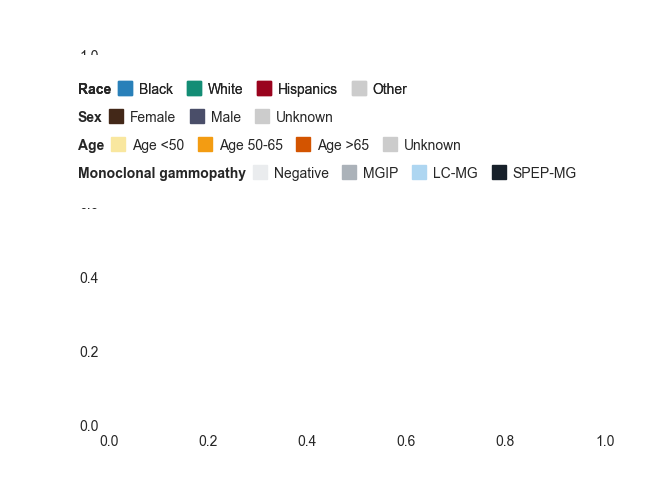

In [15]:
# LEGEND

plt.figure()
# plt.figure(figsize=(8*SIZE_PCT_OF_ORIGINAL, 6*SIZE_PCT_OF_ORIGINAL))
ax = plt.subplot(1, 1, 1)
show_titles = True
# create legends, empty for now
legends = []
# race
args = {"labels": race_order, "colors": [race_color_dict[k] for k in race_order]}
legends.append(cat_legend(**args, title="Race" if show_titles else None, title_loc="left", ncol=len(args["labels"])))
# sex
args = {"labels": sex_order, "colors": [sex_color_dict[k] for k in sex_order]}
legends.append(cat_legend(**args, title="Sex" if show_titles else None, title_loc="left", ncol=len(args["labels"])))
# age
args = {"labels": age_order, "colors": [age_color_dict[k] for k in age_order]}
legends.append(cat_legend(**args, title="Age" if show_titles else None, title_loc="left", ncol=len(args["labels"])))
# mg
args = {"labels": mg_order, "colors": [mg_color_dict[k] for k in mg_order]}
legends.append(cat_legend(**args, title="Monoclonal gammopathy" if show_titles else None, title_loc="left", ncol=len(args["labels"])))
# finally concat and plot
my_legend = vstack(legends, loc="upper right", spacing=10, frameon=True, ax=ax)
plt.show()

Finally, we will plot the barplots next to the circle plot

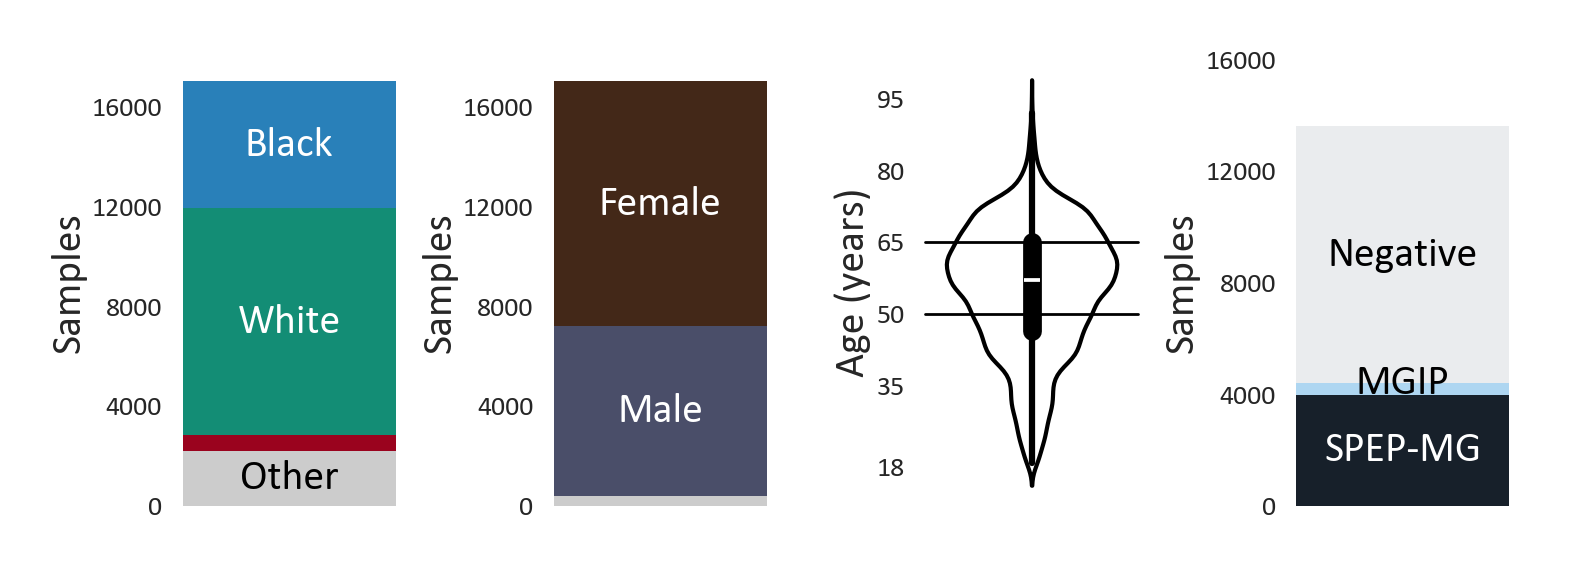

In [16]:
# THE BARPLOTS

# violin plots of the cohort

custom_font_params = font_manager.FontProperties(family='Calibri',
                                                 weight='normal',
                                                 style='normal',
                                                 size=24 * SIZE_PCT_OF_ORIGINAL)
paneltitle_font_params = font_manager.FontProperties(family='Calibri',
                                                     weight='bold',
                                                     style='normal',
                                                     size=24 * SIZE_PCT_OF_ORIGINAL)
ticks_font_params = {'family': 'Calibri', 'weight': 'normal', 'size': 16 * SIZE_PCT_OF_ORIGINAL}
labels_font_params = {"fontname": "Calibri", "fontweight": "normal", "fontsize": 24 * SIZE_PCT_OF_ORIGINAL}


def do_stackedbarplot(n, i, title, var_order, var_vector, var_color_dict, var_text_color_dict, show_yaxis):
    ax = plt.subplot(1, n, i)
    total_stack = 0
    for var in var_order:
        new_stack = (var_vector == var).sum()
        plt.bar([0], [new_stack],
                color=var_color_dict[var], bottom=[total_stack], edgecolor='white', width=1)
        if var != "LC-MG":
            plt.text(x=0, y=total_stack + new_stack / 2, s=f"{var}", color=var_text_color_dict[var],
                     verticalalignment="center", horizontalalignment="center",
                     font=custom_font_params)
        total_stack += new_stack
    # ax.set_xticklabels([], fontdict=ticks_font_params)
    if show_yaxis:
        plt.ylabel("Samples", **labels_font_params)
        plt.yticks([0, 4000, 8000, 12000, 16000])
        ax.set_yticklabels(ax.get_yticks().astype(int), fontdict=ticks_font_params)
    else:
        plt.ylabel("")
        plt.yticks([])
        plt.tick_params(
            axis='y',  # changes apply to the x-axis
            which='both',  # both major and minor ticks are affected
            left=False,  # ticks along the bottom edge are off
            right=False,  # ticks along the top edge are off
            labelleft=False)  # labels along the bottom edge are off
    plt.tick_params(
        axis='x',  # changes apply to the x-axis
        which='both',  # both major and minor ticks are affected
        bottom=False,  # ticks along the bottom edge are off
        top=False,  # ticks along the top edge are off
        labelbottom=False)  # labels along the bottom edge are off
    # plt.title(title, loc='center', font=paneltitle_font_params)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)


def do_stripplot(n, i, title, var_vector):
    import seaborn as sns
    var_vector = var_vector[~pd.isna(var_vector)]
    ax = plt.subplot(1, n, i)
    sns.violinplot(x=[0, ] * len(var_vector), y=var_vector,
                   linewidth=3., color="white", linecolor="black", ax=ax)
    sns.lineplot(x=[-.5, .5], y=[50, 50], color="black", lw=2., ax=ax)
    sns.lineplot(x=[-.5, .5], y=[65, 65], color="black", lw=2., ax=ax)
    # violin_parts = plt.violinplot(dataset=var_vector,
    #                               )
    # for pc in violin_parts['bodies']:
    #     pc.set_facecolor('white')
    #     pc.set_edgecolor('black')
    plt.yticks([18, 35, 50, 65, 80, 95])
    plt.ylabel("Age (years)", **labels_font_params)
    ax.set_yticklabels(ax.get_yticks().astype(int), fontdict=ticks_font_params)
    plt.tick_params(
        axis='x',  # changes apply to the x-axis
        which='both',  # both major and minor ticks are affected
        bottom=False,  # ticks along the bottom edge are off
        top=False,  # ticks along the top edge are off
        labelbottom=False)  # labels along the bottom edge are off
    # plt.title(title, loc='center', font=paneltitle_font_params)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)


# plt.figure(figsize=(12, 4))
plt.figure(figsize=(12*SIZE_PCT_OF_ORIGINAL, 4*SIZE_PCT_OF_ORIGINAL))
# update Oct 21: do not plot "Hispanics" because not enough space
fake_race_text_color_dict = {"White": race_text_color_dict["White"],
                             "Black": race_text_color_dict["Black"],
                             "Other": race_text_color_dict["Other"],
                             " ": race_text_color_dict["Hispanics"]}
fake_race_color_dict = {"White": race_color_dict["White"],
                        "Black": race_color_dict["Black"],
                        "Other": race_color_dict["Other"],
                        " ": race_color_dict["Hispanics"]}
fake_race_order = ['Other', ' ', 'White', 'Black']
do_stackedbarplot(n=4, i=1, title="Race",
                  var_order=fake_race_order, var_vector=filt_dataset.Sr_Race_Mod.replace({"Hispanics": " "}),
                  var_color_dict=fake_race_color_dict, var_text_color_dict=fake_race_text_color_dict,
                  show_yaxis=True)
# update Oct 21: do not plot "Unknown" because not enough space
fake_sex_text_color_dict = {"Female": sex_text_color_dict["Female"],
                            "Male": sex_text_color_dict["Male"],
                            " ": sex_text_color_dict["Unknown"]}
fake_sex_color_dict = {"Female": sex_color_dict["Female"],
                       "Male": sex_color_dict["Male"],
                       " ": sex_color_dict["Unknown"]}
fake_sex_order = [' ', 'Male', 'Female']
do_stackedbarplot(n=4, i=2, title="Sex",
                  var_order=fake_sex_order, var_vector=filt_dataset.Sex_Mod.replace({"Unknown": " "}),
                  var_color_dict=fake_sex_color_dict, var_text_color_dict=fake_sex_text_color_dict,
                  show_yaxis=True)
plt.tight_layout()
do_stripplot(n=4, i=3, title="Age",
             var_vector=filt_dataset.AGE.apply(lambda x: x if pd.isna(x) else 18 if x < 18 else 95 if x > 95 else x))
plt.tight_layout()
do_stackedbarplot(n=4, i=4, title="Monoclonal\ngammopathy",
                  var_order=mg_order[::-1], var_vector=filt_dataset.Global_Diagnosis_Mod,
                  var_color_dict=mg_color_dict, var_text_color_dict=mg_text_color_dict,
                  show_yaxis=True)
plt.tight_layout()
plt.show()